In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from collections import Counter

In [2]:
train_dataset = pd.read_csv("/content/train_data.csv")
test_dataset = pd.read_csv("/content/train_data.csv")

In [3]:
train_dataset.head()

,text,label
0,Here are Thursday's biggest analyst calls: App...,0
1,Buy Las Vegas Sands as travel to Singapore bui...,0
2,"Piper Sandler downgrades DocuSign to sell, cit...",0
3,"Analysts react to Tesla's latest earnings, bre...",0
4,Netflix and its peers are set for a ‘return to...,0


In [4]:
train_dataset["text"][0]

"Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon &amp; more  https://t.co/QPN8Gwl7Uh"

In [5]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16990 entries, 0 to 16989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16990 non-null  object
 1   label   16990 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 265.6+ KB


In [6]:
test_dataset.shape

(16990, 2)

In [7]:
def basic_informations(train_dataset, test_dataset):
  train_data_shape    = train_dataset.shape
  test_data_shape     = test_dataset.shape
  train_data_columns  = train_dataset.columns
  test_data_columns   = test_dataset.columns
  train_data_info     = train_dataset.info()
  test_data_info      = test_dataset.info()
  train_data_describe = train_dataset.describe()
  test_data_describe  = test_dataset.decribe()
  train_label_unique  = train_dataset["label"].unique()
  train_label_unique  = train_dataset["label"].value_counts()




In [8]:
test_dataset["label"].nunique()

20

"LABEL_1": "Fed | Central Banks",

"LABEL_2": "Company | Product News",

"LABEL_3": "Treasuries | Corporate Debt",

"LABEL_4": "Dividend",

"LABEL_5": "Earnings",

"LABEL_6": "Energy | Oil",

"LABEL_7": "Financials",

"LABEL_8": "Currencies",

"LABEL_9": "General News | Opinion",

"LABEL_10": "Gold | Metals | Materials",

"LABEL_11": "IPO",

"LABEL_12": "Legal | Regulation",

"LABEL_13": "M&A | Investments",

"LABEL_14": "Macro",

"LABEL_15": "Markets",

"LABEL_16": "Politics",

"LABEL_17": "Personnel Change",

"LABEL_18": "Stock Commentary",

"LABEL_19": "Stock Movement"

<ipython-input-9-c13f74c1862a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_dataset, x=train_dataset["label"], palette="hls")


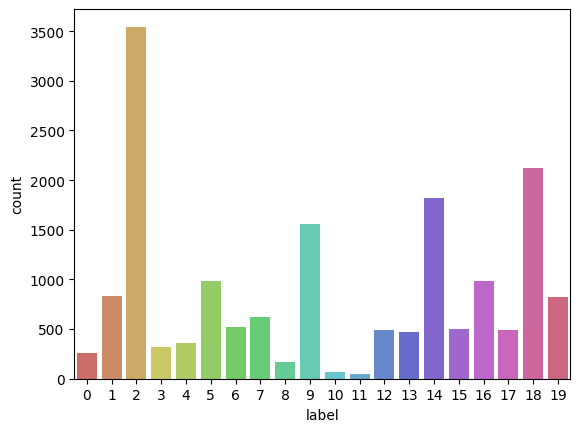

In [9]:
# test_dataset["label"].value_counts()
sns.countplot(data=train_dataset, x=train_dataset["label"], palette="hls")
plt.show()

In [10]:
train_dataset.isnull().sum()

,0
text,0
label,0


In [11]:
len(train_dataset[train_dataset["label"] == 14])

1822

In [12]:
def map_label(data):
  label_mapping = {0:0, 1:0, 2:2, 3:1, 4:1, 5:1, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4, 12:6, 13:6, 14:5, 15:7, 16:7, 17:7, 18:8, 19:9}
  data["label"] = data["label"].map(label_mapping)
  return data

In [13]:
train_copy = train_dataset.copy()
# test_copy  = test_dataset.copy()
new_train_data = map_label(train_copy)
# new_test_data = map_label(test_copy)
new_train_data.head()

,text,label
0,Here are Thursday's biggest analyst calls: App...,0
1,Buy Las Vegas Sands as travel to Singapore bui...,0
2,"Piper Sandler downgrades DocuSign to sell, cit...",0
3,"Analysts react to Tesla's latest earnings, bre...",0
4,Netflix and its peers are set for a ‘return to...,0


In [14]:
new_train_data["label"].unique()

array([0, 2, 4, 3, 1, 6, 5, 7, 8, 9])

In [15]:
new_train_data.isna().sum()

,0
text,0
label,0


In [16]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [17]:
def preprocessing(data):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    def clean_sentence(sentence):
        # Convert to lowercase
        sentence = sentence.lower()

        # Remove non-alphanumeric characters
        sentence = re.sub("[^a-z0-9]", " ", sentence)

        # Remove URLs
        sentence = re.sub(r'(http|https|ftp|ssh)://[\w_-]+(?:\.[\w_-]+)+[\w.,@?^=%&/~+#-]*[\w@?^=%&/~+#-]?', '', sentence)

        # Remove stopwords
        sentence = " ".join([word for word in sentence.split() if word not in stop_words])

        # Clean any potential HTML tags
        sentence = BeautifulSoup(sentence, "lxml").get_text()

        # Lemmatize words
        sentence = " ".join([lemmatizer.lemmatize(word) for word in sentence.split()])

        return sentence

    # Apply the cleaning function to each row
    data['text'] = data['text'].apply(clean_sentence)

    return data

In [18]:
cleaned_train_data = preprocessing(new_train_data)

In [19]:
cleaned_train_data.head()

,text,label
0,thursday biggest analyst call apple amazon tes...,0
1,buy la vega sand travel singapore build well f...,0
2,piper sandler downgrade docusign sell citing e...,0
3,analyst react tesla latest earnings break next...,0
4,netflix peer set return growth analyst say giv...,0


In [20]:
def vocabulary(data):
  words = [word for sentence in data["text"] for word in sentence.split()]
  word_counts = Counter(words)
  sorted_word_counts = word_counts.most_common()
  return sorted_word_counts

In [21]:
cleaned_train_data["text"][[0, 1]]

,text
0,thursday biggest analyst call apple amazon tes...
1,buy la vega sand travel singapore build well f...


In [22]:
# cleaned_copy = cleaned_train_data["text"].copy()
# words = [word for sentence in cleaned_copy for word in sentence.split()]

# word_counts = Counter(words)
# sorted_word_counts = word_counts.most_common()

# return sorted_word_counts, unique_words

In [23]:
word_counts = vocabulary(cleaned_train_data)

In [24]:
len(word_counts)

40007

In [25]:
def remove_words(word_counts):

  outliers = []
  for i, (w, c) in enumerate(word_counts):           ## Time Complexity is O(n)
    if c<2:
      outliers.append(w)
  word_counts = [word for word in word_counts if word[0] not in outliers]

  return word_counts

In [26]:
cleaned_word_counts = remove_words(word_counts)

In [27]:
len(cleaned_word_counts)

11855

In [28]:
def vocab_to_int(word_counts):
  word_to_int = {}
  for i, (w, c) in enumerate(word_counts):
    word_to_int[w] = i+1

  return word_to_int

In [29]:
word_to_int = vocab_to_int(cleaned_word_counts)

In [30]:
word_to_int

{'co': 1,
 'http': 2,
 'u': 3,
 'market': 4,
 'stock': 5,
 '2022': 6,
 '0': 7,
 'new': 8,
 '1': 9,
 'earnings': 10,
 'year': 11,
 'say': 12,
 'economy': 13,
 'inflation': 14,
 'business': 15,
 'bank': 16,
 'price': 17,
 '2': 18,
 'rate': 19,
 'trading': 20,
 'quarter': 21,
 'second': 22,
 'result': 23,
 'report': 24,
 'company': 25,
 'announces': 26,
 'finance': 27,
 'q2': 28,
 '3': 29,
 'stockmarket': 30,
 'first': 31,
 'call': 32,
 'investing': 33,
 '5': 34,
 'china': 35,
 'amp': 36,
 'uk': 37,
 'investor': 38,
 '4': 39,
 'share': 40,
 'energy': 41,
 'global': 42,
 '6': 43,
 'financial': 44,
 'week': 45,
 'president': 46,
 'month': 47,
 'may': 48,
 'high': 49,
 '8': 50,
 '7': 51,
 'next': 52,
 'billion': 53,
 'oil': 54,
 'revenue': 55,
 'time': 56,
 'june': 57,
 'day': 58,
 'growth': 59,
 'fed': 60,
 'beat': 61,
 'dividend': 62,
 'sale': 63,
 'ceo': 64,
 'gas': 65,
 'group': 66,
 'could': 67,
 'inc': 68,
 '9': 69,
 'one': 70,
 'point': 71,
 'via': 72,
 'interest': 73,
 'fund': 74,
 '

In [31]:
def sentence_to_numeric(sentence, word_to_int):
  numeric_sentence = [word_to_int[word] for word in sentence.split() if word in word_to_int]

  return numeric_sentence

In [32]:
text_to_numeric = cleaned_train_data["text"].apply(lambda sentence: sentence_to_numeric(sentence, word_to_int))

In [33]:
text_to_numeric

,text
0,"[448, 155, 312, 32, 248, 263, 178, 4829, 4830,..."
1,"[84, 1226, 2492, 2041, 595, 596, 600, 244, 863..."
2,"[3232, 3861, 762, 4830, 315, 1067, 1858, 80, 2..."
3,"[312, 5570, 178, 147, 10, 352, 52, 285, 530, 5..."
4,"[237, 1120, 129, 449, 59, 312, 12, 1294, 70, 5..."
...,...
16985,"[6621, 203, 250, 2458, 67, 735, 50, 814, 2560,..."
16986,"[6621, 203, 250, 2458, 67, 735, 50, 814, 2560,..."
16987,"[180, 2, 1, 315, 9, 814, 9695, 70, 11, 4174, 1..."
16988,"[42, 1172, 160, 3651, 358, 1926, 928, 100, 76,..."


In [34]:
len(text_to_numeric[0])

13

In [35]:
type(text_to_numeric[0][0])

## it is a pandas series at each row it contains list of integers

int

In [36]:
labels = cleaned_train_data["label"]

In [37]:
text_to_numeric_data = pd.DataFrame(text_to_numeric, columns=["text"])

In [38]:
text_to_numeric_data["label"] = labels

In [39]:
text_to_numeric_data.head()

,text,label
0,"[448, 155, 312, 32, 248, 263, 178, 4829, 4830,...",0
1,"[84, 1226, 2492, 2041, 595, 596, 600, 244, 863...",0
2,"[3232, 3861, 762, 4830, 315, 1067, 1858, 80, 2...",0
3,"[312, 5570, 178, 147, 10, 352, 52, 285, 530, 5...",0
4,"[237, 1120, 129, 449, 59, 312, 12, 1294, 70, 5...",0


In [40]:
def text_length(data):
  data["tweet_length"] = data["text"].apply(lambda x: len(x))

  return data

In [41]:
new_cleaned_data = text_length(text_to_numeric_data)

In [42]:
new_cleaned_data.head()

,text,label,tweet_length
0,"[448, 155, 312, 32, 248, 263, 178, 4829, 4830,...",0,13
1,"[84, 1226, 2492, 2041, 595, 596, 600, 244, 863...",0,12
2,"[3232, 3861, 762, 4830, 315, 1067, 1858, 80, 2...",0,13
3,"[312, 5570, 178, 147, 10, 352, 52, 285, 530, 5...",0,12
4,"[237, 1120, 129, 449, 59, 312, 12, 1294, 70, 5...",0,14


In [43]:
new_cleaned_data.isna().sum()

,0
text,0
label,0
tweet_length,0


In [44]:
new_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16990 entries, 0 to 16989
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          16990 non-null  object
 1   label         16990 non-null  int64 
 2   tweet_length  16990 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 398.3+ KB


In [45]:
new_cleaned_data.describe()

,label,tweet_length
count,16990.000000,16990.000000
mean,4.264567,14.512772
std,2.709531,6.013996
min,0.000000,0.000000
25%,2.000000,11.000000
50%,4.000000,14.000000
75%,7.000000,18.000000
max,9.000000,68.000000


In [46]:
def boxplot(data):

  plt.figure(figsize=(12, 5))
  sns.boxplot(data["tweet_length"])
  plt.show()

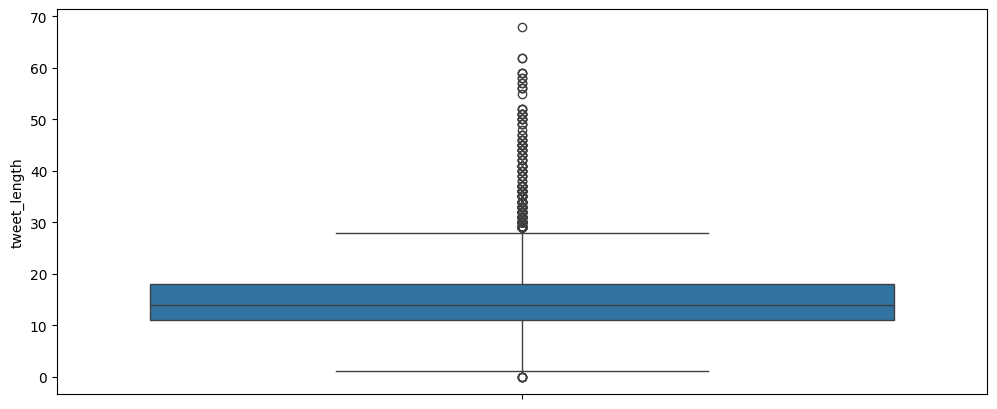

In [47]:
boxplot(new_cleaned_data)

In [48]:
len(new_cleaned_data[new_cleaned_data["tweet_length"]>30])

238

In [49]:
def remove_outliers(data, col):

  Q1 = data[col].quantile(0.25)
  Q3 = data[col].quantile(0.75)

  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  data = data.reset_index(drop=True)
  data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

  return data

In [50]:
cleaned_training_data = remove_outliers(new_cleaned_data, "tweet_length")

In [51]:
cleaned_training_data.head()

,text,label,tweet_length
0,"[448, 155, 312, 32, 248, 263, 178, 4829, 4830,...",0,13
1,"[84, 1226, 2492, 2041, 595, 596, 600, 244, 863...",0,12
2,"[3232, 3861, 762, 4830, 315, 1067, 1858, 80, 2...",0,13
3,"[312, 5570, 178, 147, 10, 352, 52, 285, 530, 5...",0,12
4,"[237, 1120, 129, 449, 59, 312, 12, 1294, 70, 5...",0,14


In [52]:
cleaned_training_data["label"].nunique()

10

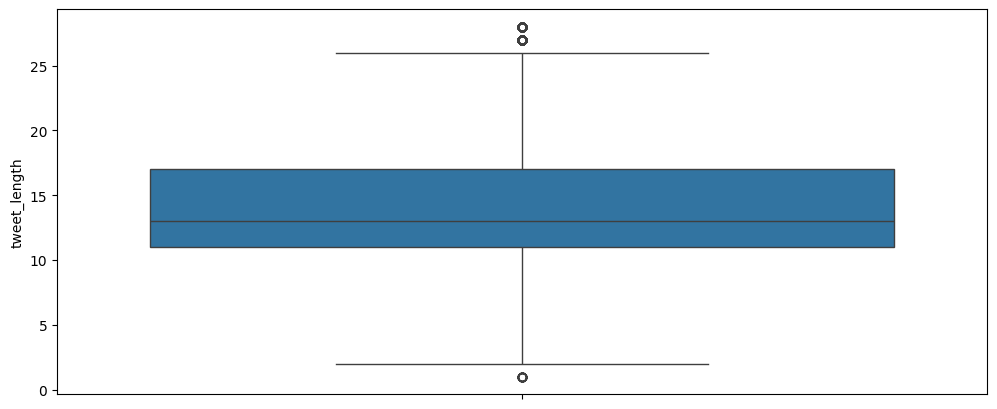

In [53]:
boxplot(cleaned_training_data)

In [54]:
cleaned_training_data.describe()

,label,tweet_length
count,16584.000000,16584.000000
mean,4.247588,14.037024
std,2.710336,5.096531
min,0.000000,1.000000
25%,2.000000,11.000000
50%,4.000000,13.000000
75%,7.000000,17.000000
max,9.000000,28.000000


In [55]:
len(cleaned_training_data[cleaned_training_data["tweet_length"] >= 27])

247

In [56]:
cleaned_training_data = cleaned_training_data[cleaned_training_data["tweet_length"] > 3]

In [57]:
cleaned_training_data.shape

(16390, 3)

In [58]:
cleaned_training_data.describe()

,label,tweet_length
count,16390.000000,16390.000000
mean,4.212630,14.176083
std,2.701087,4.962154
min,0.000000,4.000000
25%,2.000000,11.000000
50%,4.000000,13.000000
75%,7.000000,17.000000
max,9.000000,28.000000


In [59]:
def padding(sentences, seq_length):
  features = np.zeros((len(sentences), seq_length), dtype=int)

  for i, sentence in enumerate(sentences):
    features[i, -len(sentence):] = np.array(sentence)[:seq_length]

  return features

In [60]:
padded_training_data = padding(cleaned_training_data["text"], 28)

In [61]:
cleaned_training_data["text"][0]

[448, 155, 312, 32, 248, 263, 178, 4829, 4830, 2823, 36, 2, 1]

In [62]:
padded_training_data

array([[   0,    0,    0, ...,   36,    2,    1],
       [   0,    0,    0, ...,   12,    2,    1],
       [   0,    0,    0, ..., 1154,    2,    1],
       ...,
       [   0,    0,    0, ...,    1,    2,    1],
       [   0,    0,    0, ...,    1,    2,    1],
       [   0,    0,    0, ...,    1,    2,    1]])

In [63]:
cleaned_training_data.head()

,text,label,tweet_length
0,"[448, 155, 312, 32, 248, 263, 178, 4829, 4830,...",0,13
1,"[84, 1226, 2492, 2041, 595, 596, 600, 244, 863...",0,12
2,"[3232, 3861, 762, 4830, 315, 1067, 1858, 80, 2...",0,13
3,"[312, 5570, 178, 147, 10, 352, 52, 285, 530, 5...",0,12
4,"[237, 1120, 129, 449, 59, 312, 12, 1294, 70, 5...",0,14


In [64]:
# train_np_labels = np.array(cleaned_training_data["label"])

In [65]:
def np_labels(label_data):
  labels = np.array(label_data)

  return labels

In [66]:
train_np_labels = np_labels(cleaned_training_data["label"])

In [67]:
len(train_np_labels)

16390

**Applying the above created functions to test dataset**

In [68]:
def cleaned_test_dataset(test_dataset):

    dataset   = map_label(test_dataset)

    pre_data  = preprocessing(dataset)

    word_counts = vocabulary(pre_data)

    cleaned_word_counts = remove_words(word_counts)

    word_to_int = vocab_to_int(cleaned_word_counts)

    text_to_numeric = pre_data["text"].apply(lambda sentence: sentence_to_numeric(sentence, word_to_int))

    labels = dataset["label"]

    text_to_numeric_data = pd.DataFrame(text_to_numeric, columns=["text"])

    text_to_numeric_data["label"] = labels

    new_cleaned_data = text_length(text_to_numeric_data)

    cleaned_testing_data = remove_outliers(new_cleaned_data, "tweet_length")

    cleaned_test_data = cleaned_testing_data[cleaned_testing_data["tweet_length"] > 3]

    padded_test_data = padding(cleaned_test_data["text"], 28)

    test_np_labels = np_labels(cleaned_test_data["label"])

    return padded_test_data, test_np_labels





In [69]:
testing_data, test_np_labels = cleaned_test_dataset(test_dataset)

In [70]:
testing_data

array([[   0,    0,    0, ...,   36,    2,    1],
       [   0,    0,    0, ...,   12,    2,    1],
       [   0,    0,    0, ..., 1154,    2,    1],
       ...,
       [   0,    0,    0, ...,    1,    2,    1],
       [   0,    0,    0, ...,    1,    2,    1],
       [   0,    0,    0, ...,    1,    2,    1]])

In [71]:
# Creating TensorDataset and DataLoader

train_dataset  = TensorDataset(torch.from_numpy(padded_training_data), torch.from_numpy(train_np_labels))
test_dataset   = TensorDataset(torch.from_numpy(testing_data), torch.from_numpy(test_np_labels))

batch_size     = 64
train_loader   = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader    = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [72]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([64, 28])
Sample input: 
 tensor([[   0,    0,    0,  ..., 2312,    2,    1],
        [   0,    0,    0,  ...,  797,    2,    1],
        [   0,    0,    0,  ..., 1134,    2,    1],
        ...,
        [   0,    0,    0,  ...,    1,    2,    1],
        [   0,    0,    0,  ...,   84, 1201, 4207],
        [   0,    0,    0,  ...,    1,    2,    1]])
Sample input: 
 tensor([6, 7, 0, 5, 4, 0, 0, 3, 8, 7, 6, 1, 0, 1, 4, 2, 2, 5, 5, 9, 2, 2, 2, 2,
        5, 4, 1, 4, 2, 4, 2, 8, 2, 2, 2, 6, 5, 5, 9, 7, 7, 6, 9, 4, 5, 2, 1, 2,
        2, 8, 6, 5, 2, 2, 1, 2, 0, 2, 5, 5, 7, 1, 8, 3])


**Building A Model**

In [73]:
??nn.LSTM

In [74]:
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, hidden_layers, output_dim, drop_prob=0.3):
        super(LSTM_Model, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        self.drop_prob = drop_prob

        ## Embedding layer
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        ## LSTM units
        self.lstm = nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=self.hidden_layers,
                            batch_first=True)

        ## Fully connected output layer
        self.Output = nn.Linear(self.hidden_dim, self.output_dim)

        ## Softmax layer for multi-class problem
        self.softmax = nn.Softmax(dim=1)

        self.dropout = nn.Dropout(self.drop_prob)

    def forward(self, inputs, hidden, batch_size):
        ## Pass inputs to embedding layer
        embeds = self.embedding(inputs)

        ## Pass inputs to LSTM
        lstm_out, state_outputs = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        lstm_output = self.dropout(lstm_out)

        ## Pass LSTM output to fully connected layer
        output = self.Output(lstm_output)

        ## Pass to softmax layer
        output = self.softmax(output)

        ## Reshape output
        soft_out = output.view(batch_size, -1)

        ## Get last time step prediction
        soft_out = soft_out[:, -1]  # get last batch of labels

        return soft_out, state_outputs

In [75]:
vocab_size      = len(cleaned_word_counts) + 1
embedding_dim   = 64
hidden_dim      = 412
hidden_layers   = 3
output_dim      = 10

model           = LSTM_Model(vocab_size, embedding_dim, hidden_dim, hidden_layers, output_dim, drop_prob=0.3)
# model.to(device)
optimizer       = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun        = nn.CrossEntropyLoss()


In [76]:
# def calculate_accuracy(labels, actual_labels):
#   predicted_labels      = torch.argmax(labels.squeeze(), dim=1)
#   correct_pred_accuracy = torch.mean((predicted_labels == actual_labels).float()).item()

#   return correct_pred_accuracy


In [77]:
def calculate_accuracy(labels, actual_labels):
  # Check if the tensor is 0-dimensional after squeezing
  if labels.squeeze().ndim == 0:
    predicted_labels = labels.squeeze().round() # Round the single value to 0 or 1
  else:
    predicted_labels = torch.argmax(labels.squeeze(), dim=0) # Use dim=0 if the tensor is 1-dimensional
  correct_pred_accuracy = torch.mean((predicted_labels == actual_labels).float()).item()

  return correct_pred_accuracy

In [82]:
def training_model(model, optimizer, loss_fun, train_loader):
    nepochs = 2000
    losses = np.zeros(nepochs)
    accuracies = np.zeros(nepochs)

    for epoch in range(nepochs):
        model.train()
        batch_losses = []
        batch_accuracies = []

        ## Reinitialize hidden state at start of each epoch
        # h0 = torch.zeros((hidden_layers, batch_size, hidden_dim))
        # c0 = torch.zeros((hidden_layers, batch_size, hidden_dim))
        # hidden = (h0, c0)

        for inputs, labels in train_loader:
            batch_size = inputs.size(0)
            h0 = torch.zeros((hidden_layers, batch_size, hidden_dim))
            c0 = torch.zeros((hidden_layers, batch_size, hidden_dim))
            hidden = (h0, c0)
            h = tuple([each.data for each in hidden])  # Detach hidden state

            y_hat, h = model(inputs, h, batch_size)

            loss = loss_fun(y_hat.squeeze(), labels.float())

            optimizer.zero_grad()

            loss.backward()
            batch_losses.append(loss.item())

            accuracy = calculate_accuracy(y_hat, labels)
            batch_accuracies.append(accuracy)

            optimizer.step()

        losses[epoch] = np.mean(batch_losses)
        accuracies[epoch] = np.mean(batch_accuracies)

    ## Return after the loop ends
    return losses, accuracies

In [83]:
losses, accuracies = training_model(model, optimizer, loss_fun, train_loader)

KeyboardInterrupt: 

In [78]:
??nn.Softmax